In [8]:
from get_general_count_info import create_count_information
from og_marl.vault_utils.subsample_smaller import subsample_smaller_vault
from og_marl.vault_utils.analyse_vault import describe_episode_returns
from plot_oaco import plot_oaco, plot_count_frequencies, plot_reward_variability
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Processing coverage information for a multi-agent dataset

In [9]:
# set to False to reduce storage requirements
random_dataset_uid_pos = -2

In [10]:
get_variability_of="rewards" # either "reward" or "actions"
add_to_state="actions" # usually if we get variability of reward, we want it for action-state pair - so this is "actions"
var_type = f"var_{get_variability_of}_wrt_{add_to_state}"

n_trans = 20000 # for testing you may want to subsample first!!

In [11]:
rel_dir="vaults/og_marl/smac_v1"
vault_name = "3m.vlt"
keys = ["state","joint","agent0","agent1","agent2"]
vault_uids = ["Good","Medium","Poor"]

new_vault_name = vault_name.strip(".vlt")+f'_{n_trans}.vlt'

# make a smaller vault - it is easier for memory to handle
new_vault_path = subsample_smaller_vault(rel_dir,vault_name,target_number_of_transitions=n_trans)

    # for each new vault, store count information at the new vault location
for vault_uid in vault_uids:
    keys = create_count_information(
        rel_dir=rel_dir,
        vault_name=new_vault_name, 
        uid=vault_uid,
        get_variability_of=get_variability_of, # either "reward" or "actions"
        add_to_state=add_to_state, # usually if we get variability of reward, we want it for action-state pair - so this is "actions"
        store_raw_reward_info=False
        )

Vault 'vaults/og_marl/smac_v1/3m_20000' already exists. To subsample from scratch, please remove the current subsampled vault from its directory.
vaults/og_marl/smac_v1/3m_20000.vlt/Good
Loading vault found at /home/louise/workspace/og-marl/og_marl/coverage_notebooks/vaults/og_marl/smac_v1/3m_20000.vlt/Good
vaults/og_marl/smac_v1/3m_20000.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/og_marl/coverage_notebooks/vaults/og_marl/smac_v1/3m_20000.vlt/Medium
vaults/og_marl/smac_v1/3m_20000.vlt/Poor
Loading vault found at /home/louise/workspace/og-marl/og_marl/coverage_notebooks/vaults/og_marl/smac_v1/3m_20000.vlt/Poor


Loading vault found at /home/louise/workspace/og-marl/og_marl/coverage_notebooks/vaults/og_marl/smac_v1/3m.vlt/Good
Loading vault found at /home/louise/workspace/og-marl/og_marl/coverage_notebooks/vaults/og_marl/smac_v1/3m.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/og_marl/coverage_notebooks/vaults/og_marl/smac_v1/3m.vlt/Poor
Uid         Mean    Stddev    Max    Min
------  --------  --------  -----  -----
Good    16.4887    5.91525     20      0
Medium   9.95679   6.05977     20      0
Poor     4.69023   2.14219     20      0


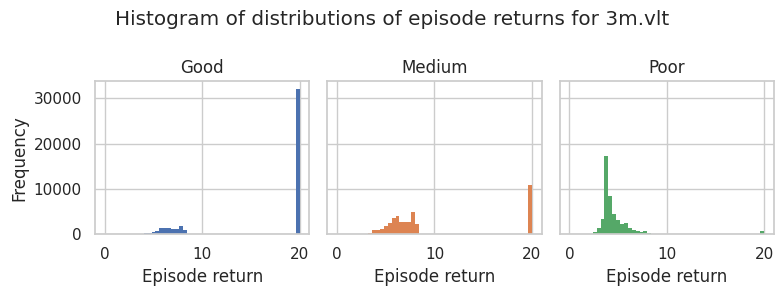

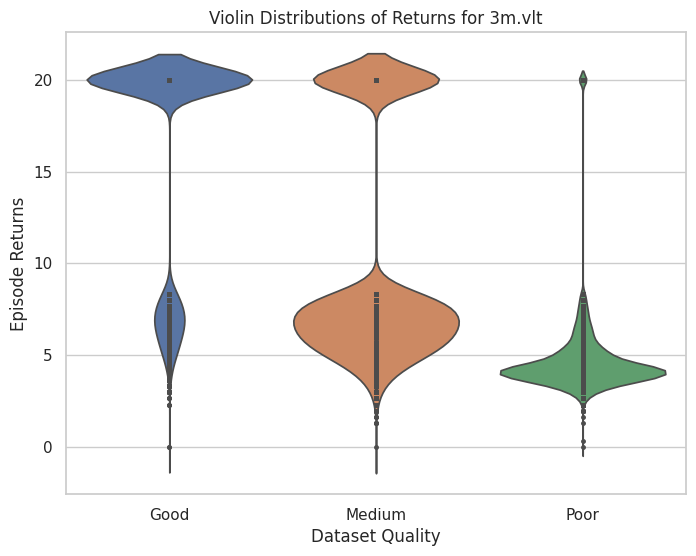

Loading vault found at /home/louise/workspace/og-marl/og_marl/coverage_notebooks/vaults/og_marl/smac_v1/3m_20000.vlt/Good
Loading vault found at /home/louise/workspace/og-marl/og_marl/coverage_notebooks/vaults/og_marl/smac_v1/3m_20000.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/og_marl/coverage_notebooks/vaults/og_marl/smac_v1/3m_20000.vlt/Poor
Uid         Mean    Stddev      Max    Min
------  --------  --------  -------  -----
Good    11.7584    6.22452  20           0
Medium   6.58792   7.14719  20           0
Poor     2.36047   2.41759  11.6712      0


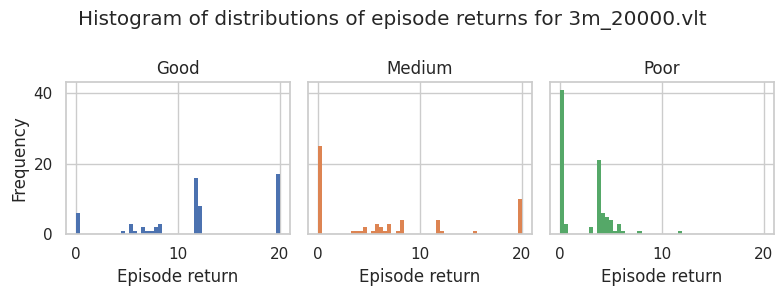

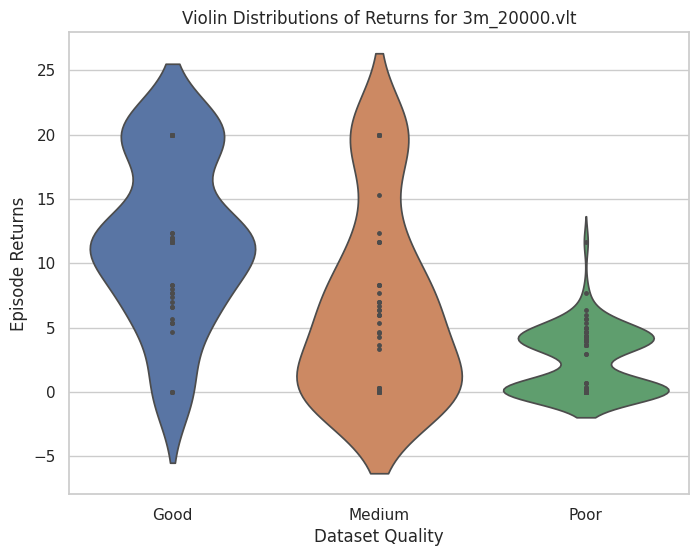

In [12]:
returns = describe_episode_returns(vault_name,vault_uids,rel_dir)
returns = describe_episode_returns(new_vault_name,vault_uids,rel_dir)

In [13]:
def plot_oaco(rel_dir,vault_name,vault_uids,random_dataset_pos=-2,norm_wrt_state=False, variability_type = "var_actions_wrt_None"):
    num_unique = {}
    for uid in vault_uids:
        with open(os.path.join(rel_dir,vault_name,uid,variability_type,"number_unique.pickle"),"rb") as f:
            num_unique[uid] = pickle.load(f)

    unique_df = pd.DataFrame(num_unique)
    unique_df.transpose

    fig, ax = plt.subplots(1,1,figsize=(13,4))

    # normalise wrt random if random dataset exists
    if random_dataset_pos!=-2:
        unique_df = unique_df.div(unique_df.iloc[:,random_dataset_pos],axis=0)

    # normalise wrt random if random dataset exists
    if norm_wrt_state:
        unique_df = unique_df.div(unique_df.iloc[-1,:],axis=1)

    sns.heatmap(unique_df,annot=True,fmt='.0f',square=False)
    # plt.title(vault_name)
    plt.xticks(rotation=30, ha='right')
    plt.savefig(rel_dir+"/"+vault_name+"/"+"OACo_heatmap.pdf",format='pdf',bbox_inches='tight')
    plt.show()
    return

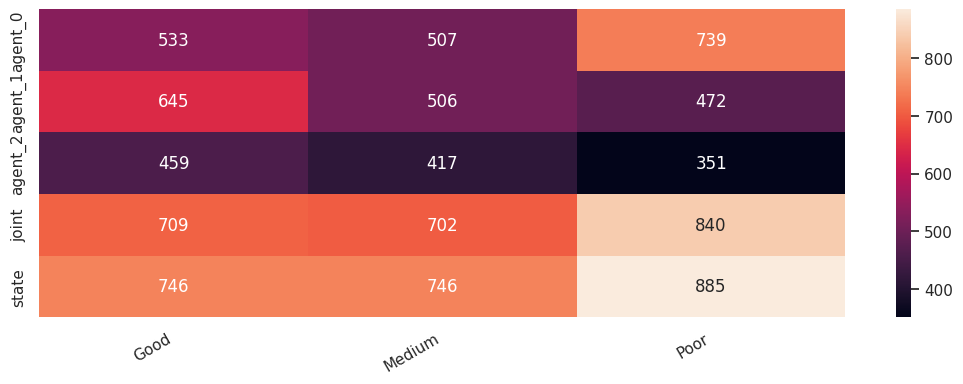

In [14]:
plot_oaco(rel_dir,new_vault_name,["Good", "Medium","Poor"],random_dataset_uid_pos,False,variability_type = var_type)

In [15]:
def plot_top_five(rel_dir,vault_name,vault_uids,variability_type): 

    colors = {
            'death':'black',
            'misc repeated':'orange',
            'non-repeated':'yellow',
            '0':'green',
            '1':'blue',
            '2':'turquoise',
            '3':'red',
            '4':'purple',
            }
    num_unique = {}
    top_5_vals = {}
    top_5_counts = {}

    for uid in vault_uids:
        sizes = {}
        labels = {}

        with open(os.path.join(rel_dir,vault_name,uid,variability_type,"number_unique.pickle"),"rb") as f:
            num_unique[uid] = pickle.load(f)

        with open(os.path.join(rel_dir,vault_name,uid,variability_type,"top_five.pickle"),"rb") as f:
           (top_5_vals[uid], top_5_counts[uid]) = pickle.load(f)

        labels_dict = {}
        sizes_dict = {}
        for key in list(num_unique[uid].keys()):
            sizes = []
            labels = []

            sizes.append(num_unique[uid][key])
            labels.append('non-repeated')

            death_state = -2
            for i,val in enumerate(top_5_vals[uid][key]):
                # print(val)
                if not val.astype(bool).any():
                    death_state = i

                    sizes.append(top_5_counts[uid][key][i])
                    labels.append("death")
                else:
                    sizes.append(top_5_counts[uid][key][i])
                    # labels.append(top_5_vals[uid][key][i])
                    labels.append(str(i))
            # print(tt(key)
            # prinop_5_vals[uid][key])
            

            # todo get exact numberprint(sum(sizes[key]))
            sizes.append(25000-sum(sizes))
            labels.append("misc repeated")

            labels_dict[key] = labels
            sizes_dict[key] = sizes

            sizes_offset = np.cumsum(sizes)-sizes

            # plt.pie(sizes, labels=labels)
            # plt.title(str(key)+str(uid))
            # plt.show()
            for i in range(len(sizes)):
                plt.bar([key],sizes[i], 0.4, bottom=sizes_offset[i],color=colors[labels[i]])
    
        plt.title(uid)
        plt.show()
    
    return

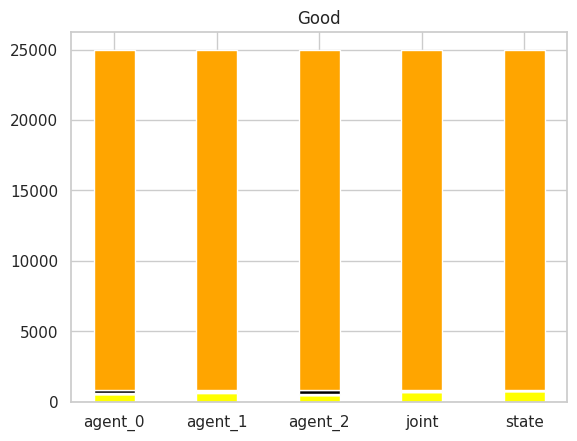

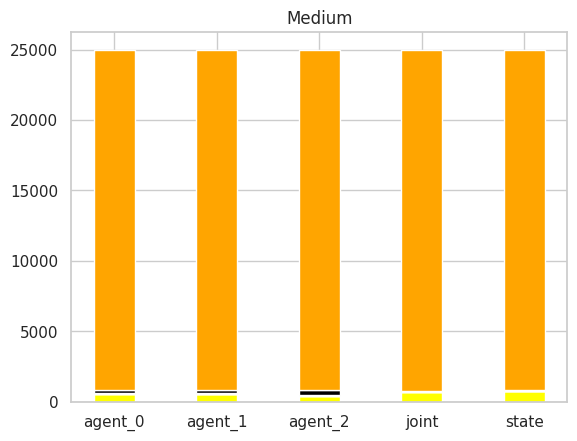

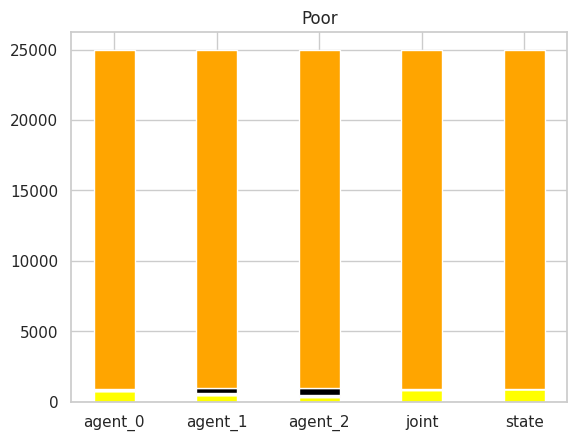

In [17]:
plot_top_five(rel_dir,new_vault_name,['Good',"Medium","Poor"],variability_type = var_type)

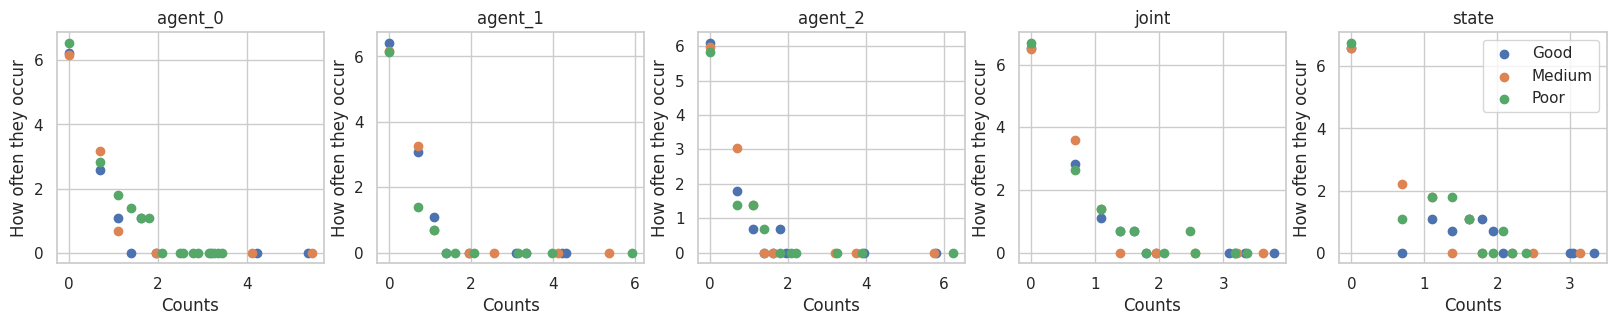

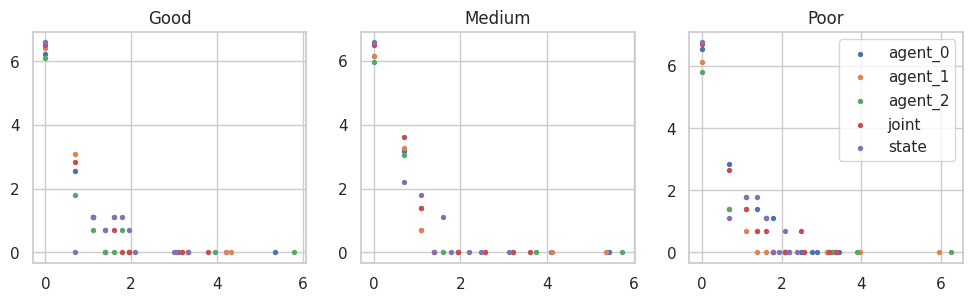

In [18]:
plot_count_frequencies(rel_dir,new_vault_name,['Good',"Medium","Poor"],variability_type=var_type)

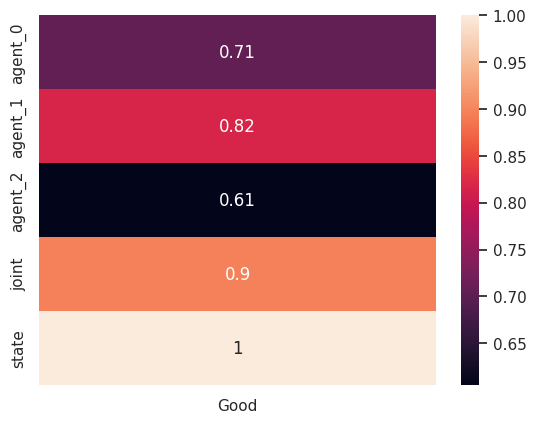

In [19]:
plot_reward_variability(rel_dir,new_vault_name,['Good'],variability_type=var_type)

In [20]:
def plot_reward_repeat_correlation(rel_dir,vault_name,vault_uids,variability_type="var_actions_wrt_None"):
    num_unique = {}
    probs = {}
    for uid in vault_uids:
        with open(os.path.join(rel_dir,vault_name,uid,variability_type,"number_unique.pickle"),"rb") as f:
            num_unique[uid] = pickle.load(f)

        with open(os.path.join(rel_dir,vault_name,uid,variability_type,"processed_reward_info.pickle"),"rb") as f:
            (probs[uid], _) = pickle.load(f)

        plt.scatter(num_unique[uid].values(),probs[uid].values(),label=str(uid))
        plt.scatter(num_unique[uid]['state'],probs[uid]['state'],marker='o',facecolors='none',edgecolors='black')

        # maybe times rewards by any 2 -> prob of getting contradicting data

    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    return

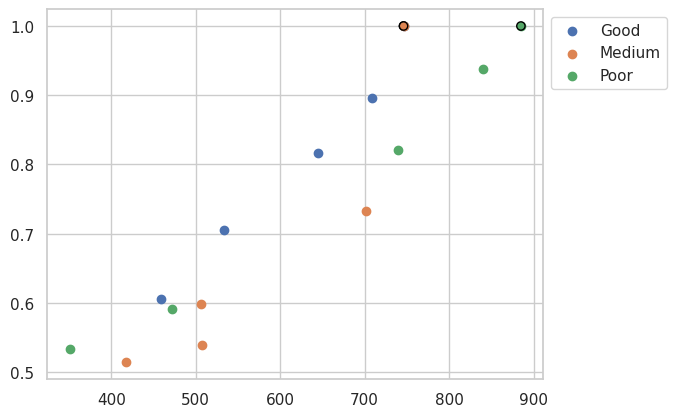

In [21]:
plot_reward_repeat_correlation(rel_dir,new_vault_name,vault_uids,variability_type=var_type)

In [22]:
rel_dir = rel_dir
uid = 'Good'
with open(os.path.join(rel_dir,new_vault_name,uid,var_type,"number_unique.pickle"),"rb") as f:
    num_unique = pickle.load(f)

with open(os.path.join(rel_dir,new_vault_name,uid,var_type,"processed_reward_info.pickle"),"rb") as f:
    (probs, _) = pickle.load(f)

In [23]:
print(probs)

{'agent_0': 0.7056226704380236, 'agent_1': 0.8169102955095171, 'agent_2': 0.6056434569029532, 'joint': 0.8958333333333333, 'state': 1.0000000000000002}
